In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Loading the daily price data
tata_steel = yf.download('TATASTEEL.NS', start='2023-01-01', end='2024-03-31')

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Calculating daily returns
tata_steel['Returns'] = 100*tata_steel['Adj Close'].pct_change().dropna()

In [4]:
# Smoothing factor
lambda_ = 0.94

# EWMA Volatility using ewm method
tata_steel['EWMA_Volatility'] = tata_steel['Returns'].ewm(alpha=(1 - lambda_)).std()


In [5]:
# VaR using EWMA Volatility
tata_steel['EWMA_VaR'] = -1.65 * tata_steel['EWMA_Volatility']  # 1.65 for 5% VaR

In [6]:
# VaR using GARCH
garch_model = arch_model(tata_steel['Returns'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")
tata_steel['GARCH_VaR'] = -1.65 * garch_fit.conditional_volatility  # 1.65 for 5% VaR


In [7]:
# Backtesting VaR forecasts
tata_steel['Actual'] = tata_steel['Returns']
tata_steel['EWMA_violations'] = tata_steel['Actual'] < tata_steel['EWMA_VaR']
tata_steel['GARCH_violations'] = tata_steel['Actual'] < tata_steel['GARCH_VaR']

In [8]:
# Calculating number of violations
ewma_violations = tata_steel['EWMA_violations'].sum()
garch_violations = tata_steel['GARCH_violations'].sum()


In [9]:
# Results
print(f"Number of EWMA VaR violations: {ewma_violations}")
print(f"Number of GARCH VaR violations: {garch_violations}")

Number of EWMA VaR violations: 14
Number of GARCH VaR violations: 12


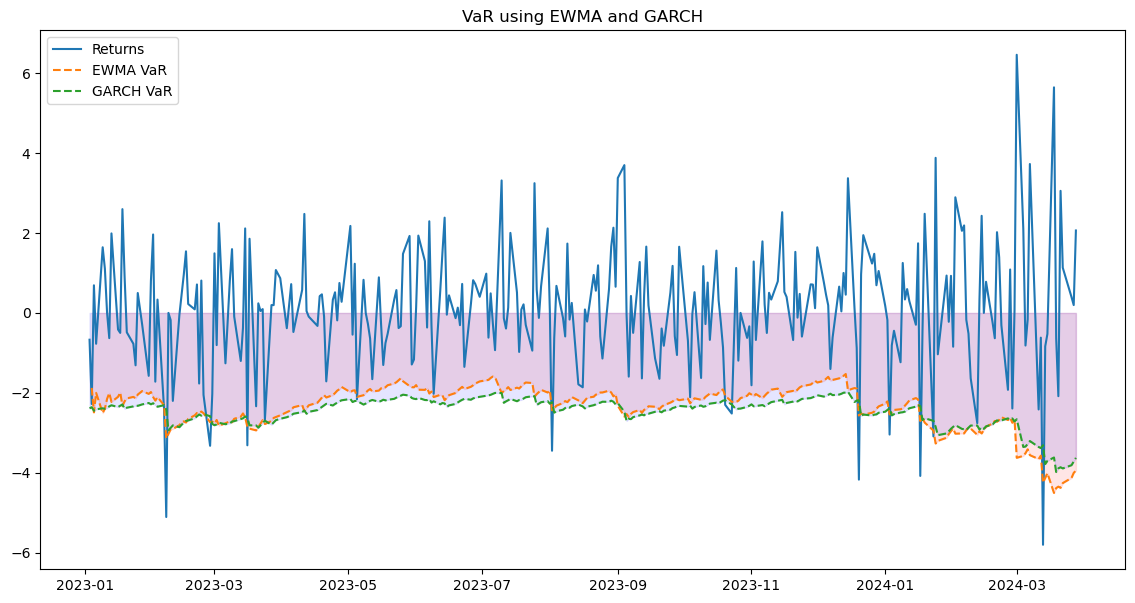

In [11]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(tata_steel['Returns'], label='Returns')
plt.plot(tata_steel['EWMA_VaR'], label='EWMA VaR', linestyle='--')
plt.plot(tata_steel['GARCH_VaR'], label='GARCH VaR', linestyle='--')
plt.fill_between(tata_steel.index, tata_steel['EWMA_VaR'], color='red', alpha=0.1)
plt.fill_between(tata_steel.index, tata_steel['GARCH_VaR'], color='blue', alpha=0.1)
plt.legend()
plt.title('VaR using EWMA and GARCH')
plt.show()
